In [1]:
import os, sys

from math import ceil

import numpy as np
import meshplot as mp
import ipywidgets
from skimage import measure
from scipy.ndimage import zoom
from scipy.interpolate import interpn
from IPython.display import display
from einops import rearrange
import igl
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import torch
from scipy import stats
import matplotlib.pyplot as plt
import pandas
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Meshplot left an annoying print statement in their code. Using this context manager to supress it...
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [3]:
# Dot product on the first dimension of n-dimensional arrays x and y
def dot(x, y):
    return np.einsum('i..., i... -> ...', x, y)

# Signed distance functions from Inigo Quilez https://iquilezles.org/articles/distfunctions/
# You could implement the smooth minimum operation as well to compose shapes together for more complex situations
def sdf_sphere(x, radius):
    return np.linalg.norm(x, axis=0) - radius

def sdf_capsule(x, a, b, r):
    xa = coords - a
    ba = coords - a
    h = np.clip(dot(xa, ba) / dot(ba, ba), 0., 1.)
    return np.linalg.norm(xa - ba * h) - r

def sdf_torus(x, radius, thickness):
    
    q = np.stack([np.linalg.norm(x[[0, 1]], axis=0) - radius, x[2]])
    return np.linalg.norm(q, axis=0) - thickness

# Crop an n-dimensional image with a centered cropping region
def center_crop(img, shape):
    start = [a // 2 - da // 2 for a, da in zip(img.shape, shape)]
    end = [a + b for a, b in zip(start, shape)]
    slices = tuple([slice(a, b) for a, b in zip(start, end)])
    return img[slices]

# Add noise to coordinates
def gradient_noise(x, scale, strength, seed=None):
    shape = [ceil(s / scale) for s in x.shape[1:]]
    if seed:
        np.random.seed(seed)
    scalar_noise = np.random.randn(*shape)
    scalar_noise = zoom(scalar_noise, zoom=scale)
    scalar_noise = center_crop(scalar_noise, shape=x.shape[1:])
    vector_noise = np.stack(np.gradient(scalar_noise))
    return vector_noise * strength



In [7]:
plot=None
@mp.interact(
    radius=(0, 0.5, 0.01), 
    thickness=(0.1, 0.25, 0.01), 
    noise_scale=(5, 25), 
    noise_strength=(0.0, 0.4, 0.05),
    seed=(1, 100)
)
def show(radius, thickness, noise_scale, noise_strength, seed):
    global plot
    global sdf
    coords = np.linspace(-1, 1, 100)
    x = np.stack(np.meshgrid(coords, coords, coords))
    x = x + gradient_noise(x, noise_scale, noise_strength, seed)
    sdf = sdf_torus(x, radius, thickness)
    verts, faces, normals, values = measure.marching_cubes(sdf, level=0)
    
    if plot is None:
        plot = mp.plot(verts, faces, return_plot=True)
    else:
        with HiddenPrints():
            plot.update_object(vertices=verts, faces=faces)
        display(plot._renderer)

interactive(children=(FloatSlider(value=0.25, description='radius', max=0.5, step=0.01), FloatSlider(value=0.1…

In [6]:
plot=None
@mp.interact(
    radius=(0, 0.5, 0.01), 
    thickness=(0.01, 0.25, 0.01), 
    noise_scale=(0.0, 40, 1),
    noise_strength=(0.0, 40, 1),
    seed=(1, 100),
    bump_angle=(-1., 1., 0.01),
    bump_width=(0.01, 0.02, 0.001),
    bump_height=(0.01, 50.),
)
def show(radius, thickness, noise_scale, noise_strength, seed, bump_angle, bump_width, bump_height):
    global plot
    coords = np.linspace(-1, 1, 100)
    x = np.stack(np.meshgrid(coords, coords, coords))
    sdf = sdf_torus(x, radius, thickness)
    verts, faces, normals, values = measure.marching_cubes(sdf, level=0)
    
    x_warp = gradient_noise(x, noise_scale, noise_strength, seed)
    print(x_warp.shape)
    
    angle = np.pi * bump_angle
    gaussian_center = np.array([np.sin(angle), 0., np.cos(angle)]) * radius
    print(gaussian_center.shape)
    x_dist = np.linalg.norm((x - gaussian_center[:, None, None, None]), axis=0)
    print(x_dist.shape)
    x_bump = bump_height * np.e ** -(1. / bump_width * x_dist ** 2)
    print(x_bump.shape)
    x_warp += -np.stack(np.gradient(x_bump))
    
    x_warp = rearrange(x_warp, 'v h w d -> h w d v')
    vertex_noise = interpn([np.arange(100) for _ in range(3)], x_warp, verts)
    verts += vertex_noise
    
    if plot is None:
        plot = mp.plot(verts, faces, return_plot=True)
    else:
        with HiddenPrints():
            plot.update_object(vertices=verts, faces=faces)
        display(plot._renderer)

interactive(children=(FloatSlider(value=0.25, description='radius', max=0.5, step=0.01), FloatSlider(value=0.1…

## Save torus data into file

In [6]:
radius=0.25 
thickness=0.10
noise_scale=20
noise_strength=0
seed=50
bump_width=0.01
bump_height=30.0

for idx, bump_angle in tqdm(enumerate(np.linspace(-1, 1, 500))):
    coords = np.linspace(-1, 1, 100)
    x = np.stack(np.meshgrid(coords, coords, coords))
    sdf = sdf_torus(x, radius, thickness)
    verts, faces, normals, values = measure.marching_cubes(sdf, level=0)    
   
    x_warp = gradient_noise(x, noise_scale, noise_strength, seed)
    
    angle = np.pi * bump_angle
    gaussian_center = np.array([np.sin(angle), 0., np.cos(angle)]) * radius
    x_dist = np.linalg.norm((x - gaussian_center[:, None, None, None]), axis=0)
    x_bump = bump_height * np.e ** -(1. / bump_width * x_dist ** 2)
    x_warp += -np.stack(np.gradient(x_bump))
    
    x_warp = rearrange(x_warp, 'v h w d -> h w d v')
    vertex_noise = interpn([np.arange(100) for _ in range(3)], x_warp, verts)
    verts += vertex_noise
    
    igl.write_triangle_mesh(f"torus_bump_500/torus_bump_{idx}.ply", verts, faces)

500it [06:11,  1.34it/s]


## Save template into file

In [146]:
radius=0.25 
thickness=0.10
noise_scale=20
noise_strength=0
seed=50
bump_width=0.01
bump_height=0.01

coords = np.linspace(-1, 1, 100)
x = np.stack(np.meshgrid(coords, coords, coords))
sdf = sdf_torus(x, radius, thickness)
verts, faces, normals, values = measure.marching_cubes(sdf, level=0)    

x_warp = gradient_noise(x, noise_scale, noise_strength, seed)

angle = np.pi * bump_angle
gaussian_center = np.array([np.sin(angle), 0., np.cos(angle)]) * radius
x_dist = np.linalg.norm((x - gaussian_center[:, None, None, None]), axis=0)
x_bump = bump_height * np.e ** -(1. / bump_width * x_dist ** 2)
x_warp += -np.stack(np.gradient(x_bump))

x_warp = rearrange(x_warp, 'v h w d -> h w d v')
vertex_noise = interpn([np.arange(100) for _ in range(3)], x_warp, verts)
verts += vertex_noise

igl.write_triangle_mesh(f"torus_bump_500/template.ply", verts, faces)

True

## Save (min-max-scaled) labels into file

In [131]:
scaler = MinMaxScaler()
labels = scaler.fit_transform(np.linspace(-1, 1, 500).reshape(-1,1))
torch.save(labels.reshape(-1), "torus_bump_500/labels.pt")

In [141]:
labels = torch.load("torus_bump_500/labels.pt")

In [104]:
x_coords = np.linspace(-1, 1, 50)
y_coords = np.linspace(-1, 1, 50)
z_coords = np.linspace(-1, 1, 50)
x = np.stack(np.meshgrid(x_coords, y_coords, z_coords))

In [105]:
x.shape

(3, 50, 50, 50)

In [106]:
def _length(a):
    return np.linalg.norm(a, axis=0)

In [107]:
def sdf_torus(x, radius, thickness):
    q = np.stack([np.linalg.norm(x[[0, 2]], axis=0) - radius, x[1]])
    return np.linalg.norm(q, axis=0) - thickness

In [108]:
_min = np.minimum
_max = np.maximum

In [109]:
def sdf_box(x):
    q = np.abs(x) -1
    print(q.shape)
    return _length(_max(q, 0)) + _min(np.amax(q, axis=0), 1)

In [110]:
def sdf_box2(x):
    q = np.abs(x)-1.5
    print(q.shape)
    return _length(_max(q, 0)) + _min(np.amax(q, axis=0), 1)

In [111]:
sdf = sdf_box(x)

(3, 50, 50, 50)


In [112]:
sdf.shape

(50, 50, 50)

In [113]:
verts, faces, normals, values = measure.marching_cubes(sdf)
verts = verts - 24.5
verts = verts / 12.5

In [114]:
mp.plot(v=verts, f=faces)

/home/hannes/anaconda3/envs/torus/lib/python3.9/site-packages/jupyter_client/session.py:716: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [137]:
from scipy.spatial import distance
scale = []
distances = []
center = np.array([0,0,1])

for i in range(verts.shape[0]):
    
    dist = distance.euclidean(center, verts[i])
    
    if dist < 0.3:
        scale.append(True)
        distances.append(dist)
    else:
        scale.append(False)
        #distances.append(dist)



In [139]:
len(distances)

44

In [130]:
scale_indices = np.nonzero(np.array(scale))[0]

In [131]:
scale_indices.shape

(44,)

In [132]:
scale_indices

array([1663, 1665, 1763, 1765, 1767, 1769, 1771, 1773, 1867, 1869, 1871,
       1873, 1875, 1877, 1969, 1971, 1973, 1975, 1977, 1979, 1981, 1983,
       2073, 2075, 2077, 2079, 2081, 2083, 2085, 2087, 2179, 2181, 2183,
       2185, 2187, 2189, 2283, 2285, 2287, 2289, 2291, 2293, 2391, 2393])

In [133]:
scale_verts = verts[scale_indices]

In [134]:
scale_verts

array([[-0.28, -0.04,  1.  ],
       [-0.28,  0.04,  1.  ],
       [-0.2 , -0.2 ,  1.  ],
       [-0.2 , -0.12,  1.  ],
       [-0.2 , -0.04,  1.  ],
       [-0.2 ,  0.04,  1.  ],
       [-0.2 ,  0.12,  1.  ],
       [-0.2 ,  0.2 ,  1.  ],
       [-0.12, -0.2 ,  1.  ],
       [-0.12, -0.12,  1.  ],
       [-0.12, -0.04,  1.  ],
       [-0.12,  0.04,  1.  ],
       [-0.12,  0.12,  1.  ],
       [-0.12,  0.2 ,  1.  ],
       [-0.04, -0.28,  1.  ],
       [-0.04, -0.2 ,  1.  ],
       [-0.04, -0.12,  1.  ],
       [-0.04, -0.04,  1.  ],
       [-0.04,  0.04,  1.  ],
       [-0.04,  0.12,  1.  ],
       [-0.04,  0.2 ,  1.  ],
       [-0.04,  0.28,  1.  ],
       [ 0.04, -0.28,  1.  ],
       [ 0.04, -0.2 ,  1.  ],
       [ 0.04, -0.12,  1.  ],
       [ 0.04, -0.04,  1.  ],
       [ 0.04,  0.04,  1.  ],
       [ 0.04,  0.12,  1.  ],
       [ 0.04,  0.2 ,  1.  ],
       [ 0.04,  0.28,  1.  ],
       [ 0.12, -0.2 ,  1.  ],
       [ 0.12, -0.12,  1.  ],
       [ 0.12, -0.04,  1.  ],
       [ 0

In [160]:
new_verts = []
for i in range(scale_verts.shape[0]):
    factor = 5 * np.exp(-distances[i]/0.1)
    new_verts.append(factor*verts[scale_indices][i][2])
    

In [161]:
new_verts

[0.2955287296958802,
 0.2955287296958802,
 0.2955287203541767,
 0.4853219192206699,
 0.6503985693006651,
 0.6503985693006651,
 0.4853219192206699,
 0.2955287203541767,
 0.4853219192206699,
 0.916110466941587,
 1.411322032261202,
 1.411322032261202,
 0.916110466941587,
 0.4853219192206699,
 0.2955287296958802,
 0.6503985693006651,
 1.411322032261202,
 2.8398535959682243,
 2.8398535959682243,
 1.411322032261202,
 0.6503985693006651,
 0.2955287296958802,
 0.2955287296958802,
 0.6503985693006651,
 1.411322032261202,
 2.8398535959682243,
 2.8398535959682243,
 1.411322032261202,
 0.6503985693006651,
 0.2955287296958802,
 0.4853219192206699,
 0.916110466941587,
 1.411322032261202,
 1.411322032261202,
 0.916110466941587,
 0.4853219192206699,
 0.2955287203541767,
 0.4853219192206699,
 0.6503985693006651,
 0.6503985693006651,
 0.4853219192206699,
 0.2955287203541767,
 0.2955287296958802,
 0.2955287296958802]

In [ ]:
x_dist = np.linalg.norm((x - gaussian_center[:, None, None, None]), axis=0)
    print(x_dist.shape)
    x_bump = bump_height * np.e ** -(1. / bump_width * x_dist ** 2)

In [ ]:
keep_indices = np.nonzero(np.array(keep))[0]

x = np.asarray(box_with_bump.points)[:,0]
y = np.asarray(box_with_bump.points)[:,1]
z = np.asarray(box_with_bump.points)[:,2]

x = x[keep_indices]
y = y[keep_indices]
z = z[keep_indices]

box_with_bump.points = o3d.utility.Vector3dVector(np.stack([x, y, z], axis=1))
box_with_bump.estimate_normals()
o3d.visualization.draw_geometries([box_with_bump], point_show_normal=True)

In [116]:
df = pd.DataFrame(verts, columns=["x", "y", "z"])
df.describe()

,x,y,z
count,4.056000e+03,4.056000e+03,4.056000e+03
mean,3.009623e-08,-4.232283e-09,-1.881014e-09
std,7.572811e-01,7.572811e-01,7.572811e-01
min,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,-7.600000e-01,-7.600000e-01,-7.600000e-01
50%,0.000000e+00,0.000000e+00,0.000000e+00
75%,7.600000e-01,7.600000e-01,7.600000e-01
max,1.000000e+00,1.000000e+00,1.000000e+00


In [87]:
df[(df.x == 24) & (df.y == 25) & (df.z == 24)]

,x,y,z


<AxesSubplot:ylabel='Frequency'>

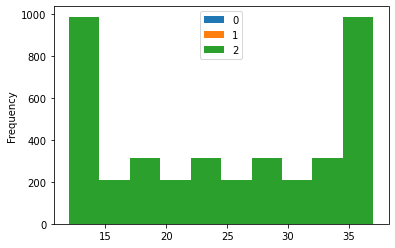

In [63]:
pd.DataFrame(verts).plot.hist()

In [34]:
verts.shape

(4056, 3)

In [45]:
verts[1000] = verts[1000]+20

In [46]:
mp.plot(v=verts, f=faces)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(24.5, 24.…